In [1]:
import scipy.signal as signal
import numpy as np 
import os, csv

In [2]:
import matplotlib.pylab as plt

In [3]:
% matplotlib inline

In [4]:
def load_data(subject_id, listen=0): 
    """inputs: 'day' = int [1 OR 2]
    returns a list of all subjects in gaze directory matching 'day'"""

    day=1
    data_file_names = []
    data_path = '../../collection/gaze_data/'
    folder_contents = os.listdir(data_path)
    
    for file in folder_contents: 
        if 'd%s.asc'%day in file and not 'x' in file: 
            data_file_names.append(file)
                
    for file_name in data_file_names: 
        if subject_id in file_name: 
            subject_path = data_path + file_name
            if listen: print("loading data from subject'%s'"%file_name) 

    with open(subject_path) as f:
        reader = csv.reader(f, delimiter="\t")
        subject_data = list(reader)

    return subject_data

def extract_data(subject_data): 
    """ 
    inputs: 'subject_data' = raw ascii file 
    returns: np.arrays for pupil, CS+, CS-, US, and movie_frame information 
    
    """

    _pupil_ = [] 
    onsets  = []
    cs_type = []
    xy = []
    cs_pos = []; cs_p = 0 # CS+
    cs_neg = []; cs_n = 0 # CS-
    us_sti = []; us_o = 0 # US

    # movie frame data prep 
    m_frame, i_frame = [], np.nan

    for i_row in range(len(subject_data)): 

        msg = subject_data[i_row]  

        try: 
            int(subject_data[i_row][0])
            # 3 = pupil column
            datum = float(msg[3]) 
            _pupil_.append(datum)
            cs_pos.append(cs_p)
            cs_neg.append(cs_n)
            us_sti.append(us_o)
            m_frame.append(i_frame)
            
            # extract xy coordinates 
            if ' .' in msg[1] or ' .' in  msg[2]:
                xy.append([np.nan, np.nan])
            else: 
                xy.append([float(msg[1]), float(msg[2])])
            
        except: 

            if len(msg) > 1: 
                if 'CS+' in msg[1]: cs_p = 1
                if 'CS-' in msg[1]: cs_n = 1
                if 'US'  in msg[1]: 
                    us_o = 1
                    cs_type[-1] =  cs_type[-1] + 'US'
                    
                    
                if 'OFF' in msg[1]: 
                    cs_p = 0
                    cs_n = 0
                    us_o = 0 

                if msg[0] == "MSG": 

                    if "VFRAME" in msg[1]: 

                        ind = str.find(msg[1], "VFRAME")
                        space = str.find(msg[1], " 0 0 /")
                        i_frame = int(msg[1][ind+7:space])
                    
                    if "TRIAL_ONSET" in msg[1]:
                        onsets.append(len(_pupil_))
                        cs_type.append(msg[1][-3:])
                    
                        
    
    data = {"pupil":np.array(_pupil_), 
            "CS+":np.array(cs_pos), 
            "CS-":np.array(cs_neg), 
            "US":np.array(us_sti), 
            "movie_frame":np.array(m_frame),
            "xy":np.array(xy), 
            "onsets":np.array(onsets),
            "cs_type":cs_type}
                    

    return data



In [5]:
subjects = ['12', '08']; i_subject = 1 
subject_data = load_data(subjects[i_subject], listen=1)

loading data from subject's08_d1.asc'


In [6]:
data = extract_data(subject_data) ; print('experimental information in data: ', list(data.keys())) 

experimental information in data:  ['pupil', 'CS+', 'CS-', 'US', 'movie_frame', 'xy', 'onsets', 'cs_type']


In [25]:
model_image = plt.imread('model_image.png')
y_len, x_len, _ = np.shape(model_image)

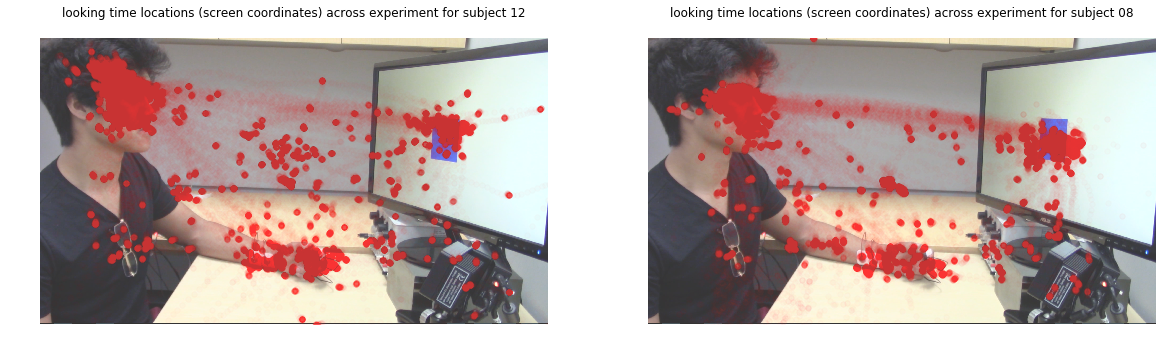

In [8]:
big_picture = 0

plt.figure(figsize=[20,8])
for i_subject in range(len(subjects)):  

    plt.subplot(1,2,i_subject+1); plt.axis('off')
    plt.imshow(model_image, alpha=.8)
    
    subject_data = load_data(subjects[i_subject])
    data = extract_data(subject_data)
        
    # need to do some rescaling to format gaze data with arbitrary-size jpeg
    plt.scatter(data['xy'][:,0]*1.9-200, data['xy'][:,1]*1.9-50,marker='o', s=30, alpha=.01, c = 'red')
    plt.title('looking time locations (screen coordinates) across experiment for subject %s\n'%subjects[i_subject]); 

    if not big_picture: plt.xlim([0, x_len]), plt.ylim([y_len, 0])

```
                          is that lower left shift towards their own hand? 
```

In [10]:
subject_data = load_data('12')
data = extract_data(subject_data)

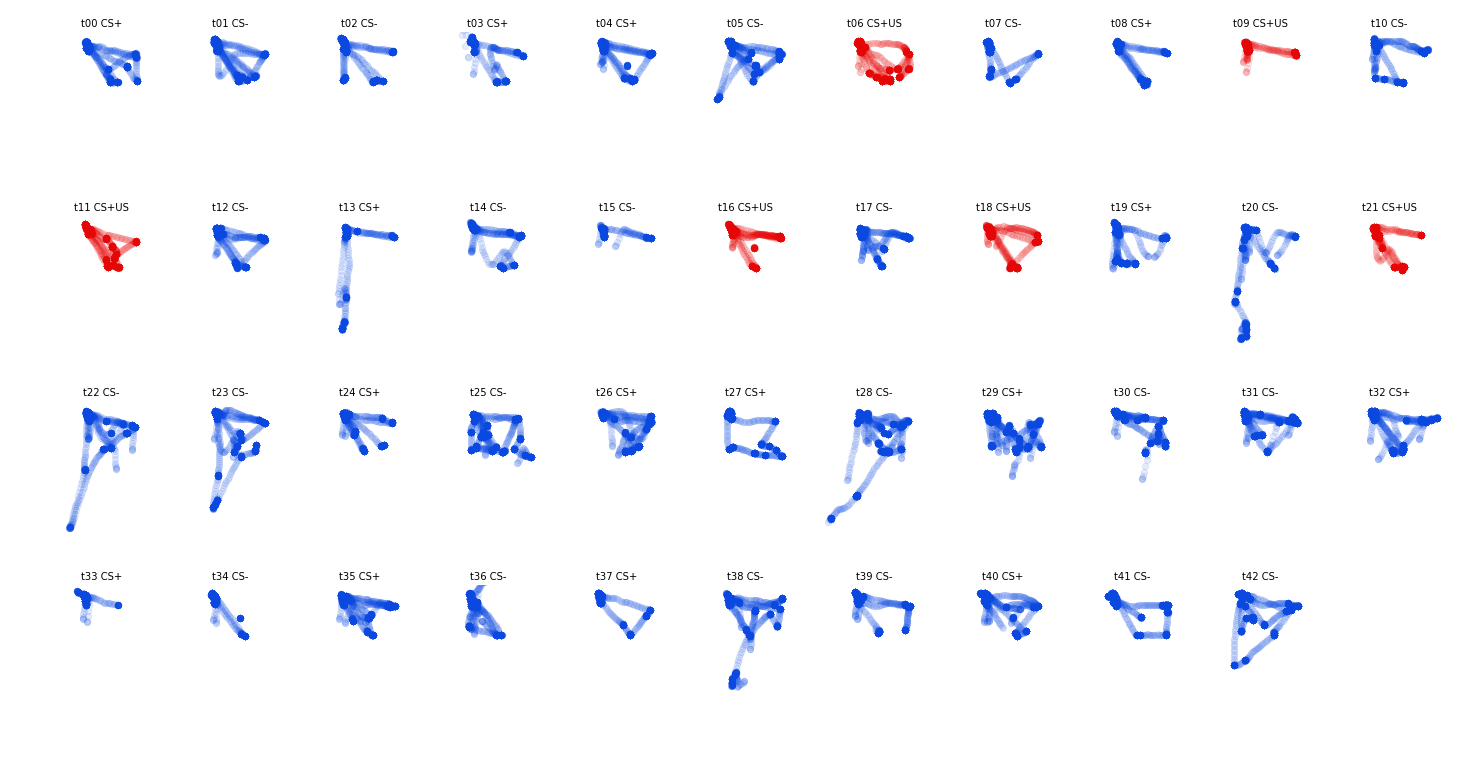

In [11]:
# interval info
xy = data['xy']
#show = np.insert(data['onsets'],0, 0)
show = data['onsets']

def set_color(cs_type): 
    if '+' in cs_type: color = 'blue'
    if '-' in cs_type: color = 'blue'
    if 'US'in cs_type: color = 'red'
    return color

# aesthetics
plt.figure(figsize=[25,13]); 
for ii in range(len(show)-1): 
    
    plt.subplot(4,11,ii+1)
    plt.xlim([-500, 2000]) ; 
    plt.ylim([-2500, 0])
    plt.axis('off')
    
    plt.scatter(xy[show[ii]:show[ii+1],0],-xy[show[ii]:show[ii+1],1], 
                marker='o', s=40, alpha=.1, c = 'xkcd:%s'%set_color(data['cs_type'][ii])); 
    plt.title('\nt%02d %s'%(ii, data['cs_type'][ii]), fontsize=10)

```
                                is there more entropy after conditioning is over?
```


					gaze behavior across the experiment


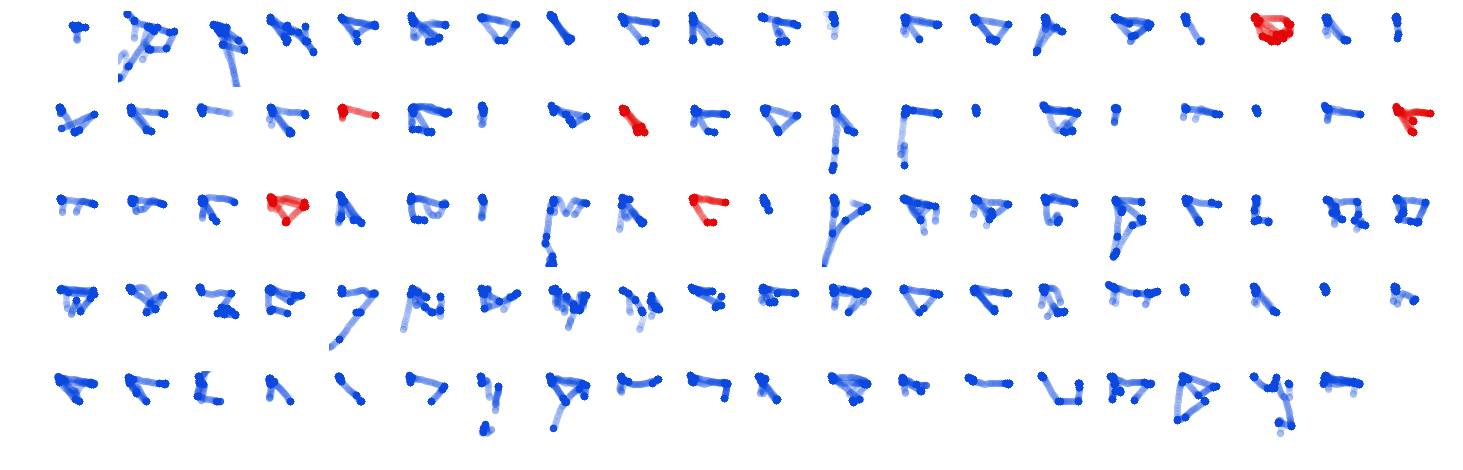

In [12]:
start, end = 0, len(data['xy']) 
step = round((end-start)/100)
show = np.arange(start, end, step)

# define US onsets in experiment
us_onsets = np.nonzero(np.convolve(data['US'], [1,-1]))[0]

def find_color(interval_0, interval_1, us_onsets, color = 'xkcd:blue'):    
    for i_onset in us_onsets: 
        if interval_0 < i_onset < interval_1: color = 'xkcd:red' 
    return color

plt.figure(figsize=[25,8]); 
for ii in range(len(show)-1): 
    
    # aesthetics
    plt.subplot(5,20,ii+1)
    plt.axis('off')
    plt.xlim([0, 2000]) ; 
    plt.ylim([-2000, 0])
    
    # plot data with US dependent color
    color = find_color(show[ii], show[ii+1], us_onsets)
    plt.scatter(data['xy'][show[ii]:show[ii+1],0],-data['xy'][show[ii]:show[ii+1],1], 
                marker='o', s=40, alpha=.1, c = '%s'%color);

print('\n\t\t\t\t\tgaze behavior across the experiment')

```
                                again, more entropy after conditioning is over?
```

In [13]:
subjects = ['12', '08', '01', '11']; i_subject = 1 
subject_data = load_data(subjects[i_subject], listen=1)

loading data from subject's08_d1.asc'


> a possible approach: 
> - kmeans clustering (k = 3) on each subjects whole timecourse
> - assuming clusters are in a "reasonable" location
>    - use the total `inertia_` for each subject as a measure of attention -- one covariate
>    - use trial-level `inertia_` as a measure of attention -- or entropy 

In [14]:
from sklearn.cluster import KMeans as kmeans

In [15]:
def kmeans_coordinates(xy, with_image=0): 
    
    if with_image: a = 1
    else: a = - 1
    
    # ignore nans, flip (?) y axis, fit model
    keep_inds = xy[:,0] == xy[:,0]
    xy = xy[keep_inds] 
    # correct for inversion depending on image type
    xy[:,1] = a*xy[:,1]
    k = kmeans(n_clusters=3, random_state=0).fit(xy)
    
    return k, xy

k = kmeans_coordinates(data['xy'])

In [16]:
def generate_clusters(subjects, show=1):
    
    big_picture = 0
    
    cluster_data = {}
    
    # colors, shape
    colors = ['#00ccff', '#ff00ff', '#00ffaa'] #6600ff'] 
    y_len, x_len, _ = np.shape(model_image)
    cluster_data['image_dims'] = {'x_len':x_len, 'y_len':y_len}
    
    # fits gaze data to arbitrary jpeg
    scaling_factor = 1.8

    if show: plt.figure(figsize=[15, 12])

    for i_subject in range(len(subjects)):
        
        subject_name = subjects[i_subject]

        # get subject's data
        subject_data = load_data(subject_name)
        data = extract_data(subject_data)
        
        # generate clusters
        k, xy = kmeans_coordinates(data['xy']*scaling_factor, with_image=1)
        
        # save 
        cluster_data['%s'%subject_name] = {'data':data, 'k':k, 'xy':xy}
        
        if show: 
            
            # find data to color mapping
            point_colors = [colors[ii] for ii in k.labels_]
            # setup plot
            plt.subplot(2,2,i_subject+1); plt.axis('off')
            # show background experimental stimuli
            plt.imshow(model_image, alpha=.5)
            # plot gaze data according to cluster color
            plt.scatter(xy[:,0],xy[:,1],  alpha=.01, c = point_colors)
            # extract centers of mass for each cluster
            centers = np.round(k.cluster_centers_)

            # plot center of mass for each cluster in a way we can clearly lable in legend
            for i_loc in range(len(centers)):
                plt.scatter(centers[i_loc][0], centers[i_loc][1], s=250, c='k')
                plt.scatter(centers[i_loc][0], centers[i_loc][1], 
                            s=180, c=colors[i_loc], label='cluster_%s'%i_loc)
                plt.annotate(i_loc, xy=(centers[i_loc][0], centers[i_loc][1]), 
                             xytext=(-4, -4), textcoords='offset points', alpha=1, fontsize=11)

            # control aesthetics
            if not big_picture: 
                plt.xlim([0, x_len]), 
                plt.ylim([y_len, 0])
            plt.legend(['cluster_1', 'cluster_2', 'cluster_3']); ax = plt.gca(); ax.legend(loc=3)
            plt.title("\n%s experimental average from centers of mass: %.02f pixels\n" 
                      %(subjects[i_subject], np.sqrt(k.inertia_/len(xy)) ) )

    
    return cluster_data

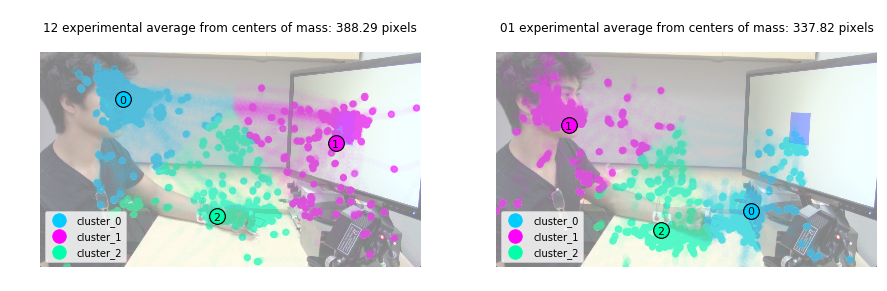

In [17]:
subjects = ['12', '01'] 
structured_data = generate_clusters(subjects)

```
average values from the centers of mass 

1) across the whole experiment can be an estimate of how much subjects were paying attention
    - e.g.'12' less focused than '08'because they're, for example, looking at the center of the screen more
2) can also be calculated within a single trial 
    - a measure how focused they were in a smaller time window
    - obvi some problems with this, but it's a start


alsoooooo subject '01' has a pretty different patter of attention ... :) 
```
> a sketch of an anaysis for a **`type 2`** analysis is below

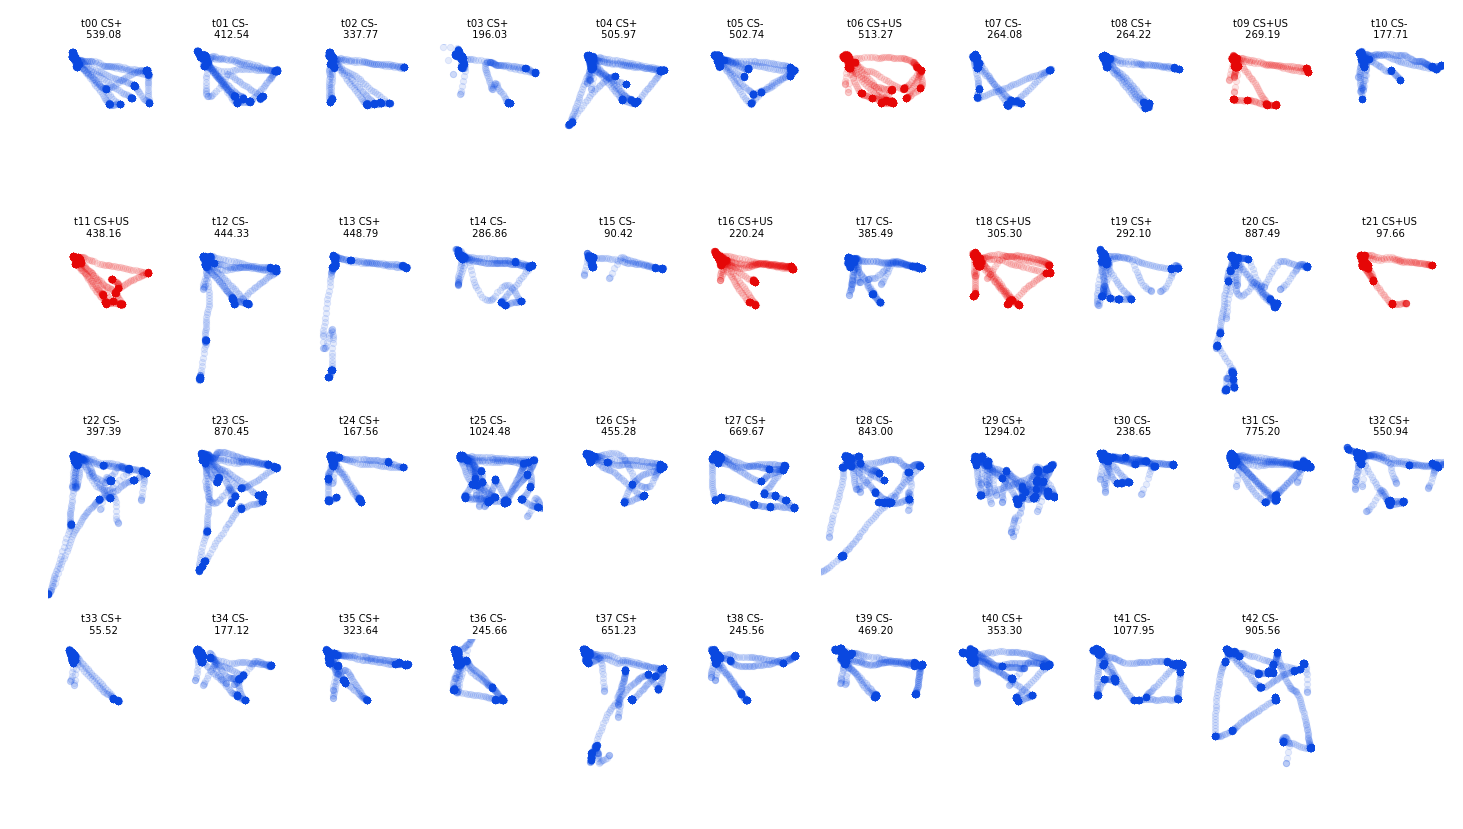

In [18]:
x_len, y_len = structured_data['image_dims']['x_len'], structured_data['image_dims']['y_len']
e_sub = structured_data['12']

data = e_sub['data'] 
show = data['onsets']
k =  e_sub['k']
xy = e_sub['xy'] 

gaze_exploration = [] 

# aesthetics
plt.figure(figsize=[25,14]); 
for ii in range(len(show)-1): 
        
    gaze_within = xy[show[ii]:show[ii+1]] 
    lab_within = k.labels_[show[ii]:show[ii+1]]
    ss_cluster_difference = np.zeros(3)
    
    for i_lable in [0,1,2]:         
        gaze_clustered = gaze_within[lab_within==i_lable]
        if not len(gaze_clustered): gaze_clustered = np.zeros([2,2])
        ss_cluster_difference[i_lable] = sum(sum((gaze_clustered - k.cluster_centers_[0])**2))

    interval_exploration = np.sum(ss_cluster_difference)/10e6
    plt.subplot(4,11,ii+1)
    plt.xlim([0, 3000]), 
    plt.ylim([-4000, 0])
    plt.axis('off')
    
    plt.scatter(xy[show[ii]:show[ii+1],0],-xy[show[ii]:show[ii+1],1], 
                marker='o', s=40, alpha=.1, c = 'xkcd:%s'%set_color(data['cs_type'][ii])); 
    
    
    plt.title('\nt%02d %s\n %.02f' 
              %(ii, data['cs_type'][ii], interval_exploration ), fontsize=10)
    
    gaze_exploration.append(interval_exploration) 

gaze_exploration = np.array(gaze_exploration)

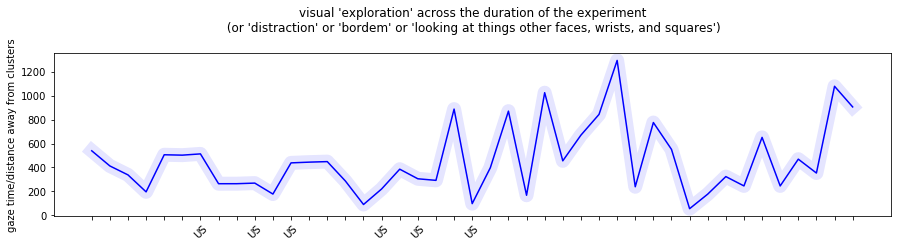

In [19]:
plt.figure(figsize=[15,3])
plt.plot(gaze_exploration, 'b')
plt.plot(gaze_exploration, 'b', linewidth=14, alpha=.1)
plt.xticks(range(0,len(gaze_exploration)), [data['cs_type'][ii][3:] for ii in range(len(data['cs_type']))], rotation=45); 
plt.title("visual 'exploration' across the duration of the experiment\n (or 'distraction' or 'bordem' or 'looking at things other faces, wrists, and squares')\n")
plt.ylabel('gaze time/distance away from clusters'); 

In [20]:
from scipy import stats
_ , p_val = stats.ttest_ind(gaze_exploration[6:22], gaze_exploration[22:])
print("\n\nthere's a significant (p < %.02f) difference between conditioning and extinction in gaze 'exploration'\n\n"%p_val)



there's a significant (p < 0.03) difference between conditioning and extinction in gaze 'exploration'




In [21]:







# validation to make sure we're performing our calculations on clusters that make sense









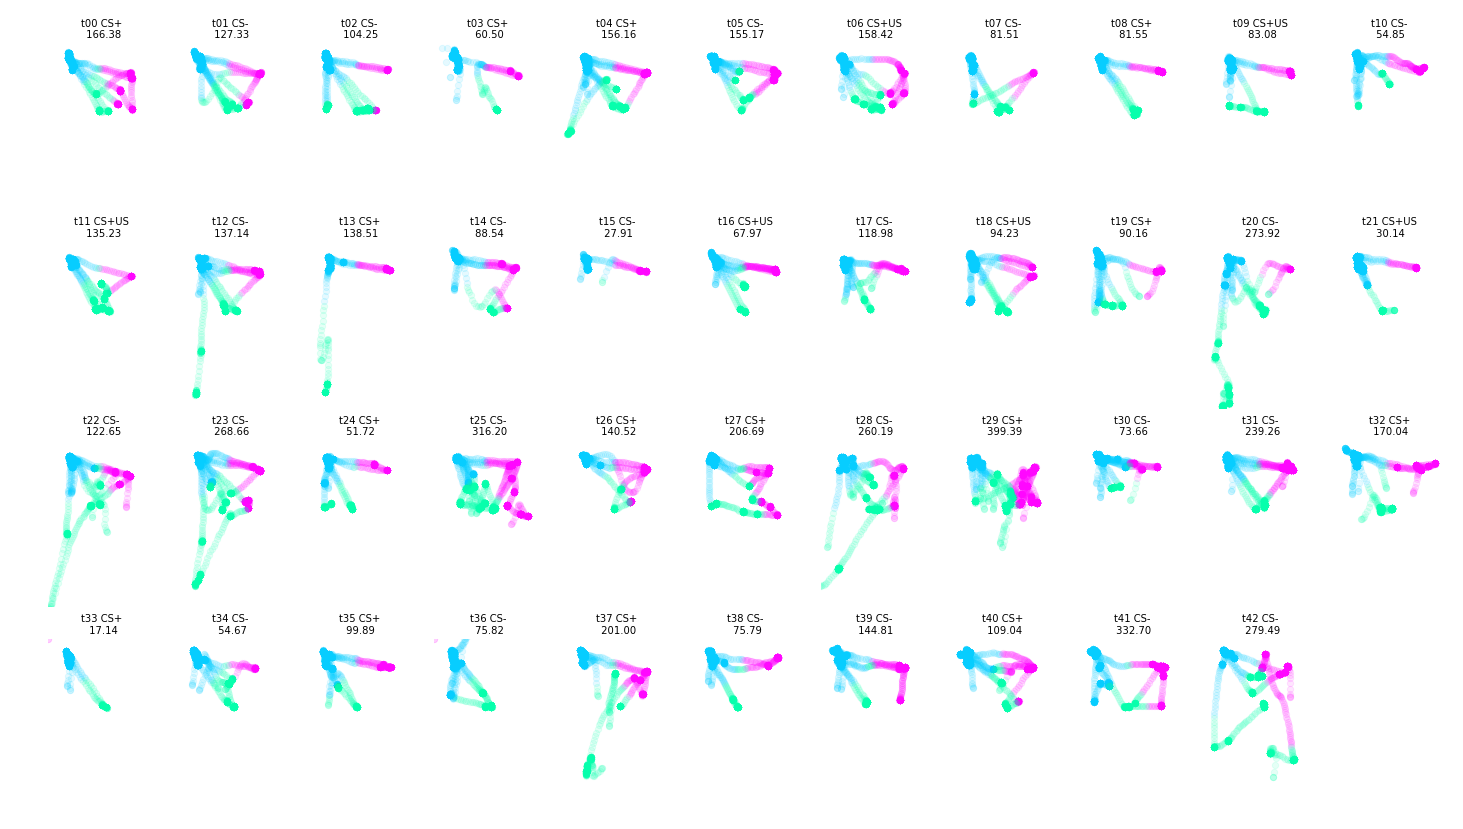

In [23]:
# get subject's data
subject_data = load_data(subjects[0])
data = extract_data(subject_data)

# generate clusters and find data to color mapping
k, xy = kmeans_coordinates(data['xy'], with_image=1)
show = data['onsets']

# aesthetics
plt.figure(figsize=[25,14]);
colors = ['#00ccff', '#ff00ff', '#00ffaa']

for ii in range(len(show)-1): 
        
    gaze_within = xy[show[ii]:show[ii+1]] 
    lab_within = k.labels_[show[ii]:show[ii+1]]
    ss_cluster_difference = np.zeros(3)
    
    plt.subplot(4,11,ii+1)
    plt.xlim([0, 2000]) ; 
    plt.ylim([-2000, 0])
    plt.axis('off')
    
    for i_lable in [0,1,2]:         
        gaze_clustered = gaze_within[lab_within==i_lable]
        if not len(gaze_clustered): gaze_clustered = np.zeros([2,2])
        ss_cluster_difference[i_lable] = sum(sum((gaze_clustered - k.cluster_centers_[0])**2))
        plt.scatter(gaze_clustered[:,0], -gaze_clustered[:,1], marker='o', s=40, alpha=.1, c =colors[i_lable]); 
    
    plt.title('\nt%02d %s\n %.02f' 
              %(ii, data['cs_type'][ii], (np.sum(ss_cluster_difference)/10e6) ), fontsize=10)
    





```
TO DO

    - introduce "calibration" at end of experiment to localize wrist, shock box (+foils), etc. 
    - talk to Russ about graph approaches to analyzing the data
        - "The geometric/graphical structure of attention"
```
> 


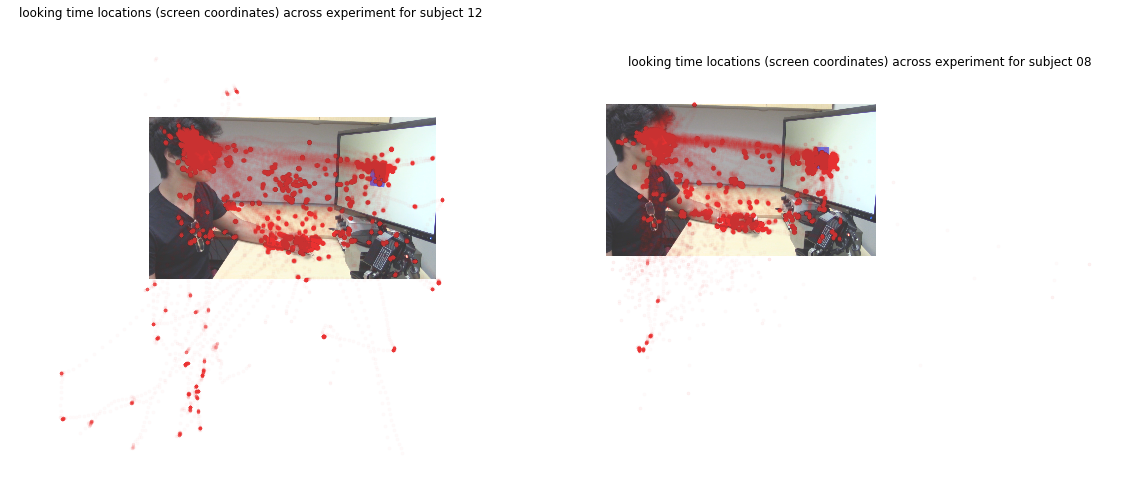

In [9]:
big_picture = 1

plt.figure(figsize=[20,8])
for i_subject in range(len(subjects)):  

    plt.subplot(1,2,i_subject+1); plt.axis('off')
    plt.imshow(model_image, alpha=.8)
    
    
    subject_data = load_data(subjects[i_subject])
    data = extract_data(subject_data)
        
    plt.scatter(data['xy'][:,0]*1.9-200, data['xy'][:,1]*1.9-50,marker='.', s=30, alpha=.02, c = 'xkcd:red')
    plt.title('looking time locations (screen coordinates) across experiment for subject %s\n'%subjects[i_subject]); 

    if not big_picture: plt.xlim([0, x_len]), plt.ylim([y_len, 0])

In [ ]:
subject_data[10000:10020]